## Web Scraper and Geolocation Query
- Description: Use BeautifulSoup to web scrape whiskybase.com to get a list of all potential distilleries and countries, and then use geopy to get an associated lat/long for the distillery in question from the address found or country to be used for data visualization purposes
- Goal : Create a repository/database of information for use of merging whiskey tasting notes to for dashboard development. The main objective is to use this mined data to isolate lat/long data to plot on a map where the whiskey tasting notes tied to a distillery are located per request of tasters who want to see where they've tasted whiskey from.
- Author: Kimberly Gaddie
- Date Last Updated: 29 August 2022

### Web Scrape to Gather Distillery Information

Whiskybase is a website which contains a massive directory of whisky distilleries around the globe and allows users to input their own ratings for whiskies they've tasted. One benefit this website offers is a detailed repository of numerous distilleries to include country of location and names. As the directory is updated quite frequently, the desire is to text mine this web page and grab the list of distilleries and their associated countries to later be funneled through additional functions to isolate latitude and longitude coordinates for each distillery.

##### Import Libraries

In [3]:
from bs4 import BeautifulSoup #Primary Web Scraping Package
import pandas as pd # Data manipulation package
import numpy as np # Number manipulation package
import requests # used to simplify the request for beautifulsoup webscrape
from datetime import datetime # used to show runtime for webscrape and geolocation portion of scripts

# Many timeout issues are likely to happen when web scraping so due to the desire of keeping the notebook clean and tidy, the warnings import and filter is included to mitigate any "noise" from warnings as the script is run.
import warnings
warnings.filterwarnings("ignore")

##### Set Parameters and Read in Base HTML

In [4]:
# First step is to define the URL where the data will be scraped
URL = "https://www.whiskybase.com/whiskies/distilleries"
# Often there are issues in regards to being able to grab the proper formatting and HTML Text. Including the Headers code here enables the computer to more easily tap into the website/url selected and process the HTML Script
headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246"}

#Performing the HTML WebScrape
r = requests.get(url=URL, headers=headers)
soup = BeautifulSoup(r.content, 'html5lib')
#HTML input is often quite nasty to interpret and thus the soup.prettify() command formats the parsed HTML script from the URL into a more legible format that can be reviewed to best select the portion of the code that we want to isolate
print(soup.prettify())

<!-- Version: 3.10.0 -->
<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <script>
   document.documentElement.className += 'js'
  </script>
  <link href="https://assets.whiskybase.com/assets/css/wb.css?3.10.0" rel="stylesheet" type="text/css"/>
  <link href="https://assets.whiskybase.com/assets/css/themes/base.css?3.10.0" rel="stylesheet" type="text/css"/>
  <link href="https://assets.whiskybase.com/assets/css/ui.css?3.10.0" rel="stylesheet" type="text/css"/>
  <link href="https://www.whiskybase.com/whiskies/distilleries" rel="canonical"/>
  <title>
   Distilleries - Whiskybase - Ratings and reviews for whisky
  </title>
  <meta content="#588699" name="theme-color"/>
  <meta content="#588699" name="msapplication-navbutton-color"/>
  <meta content="#588699" name="apple-mobile-web-app-status-bar-style"/>
  <meta content="Whiskybase: discover new bottles, track your collection, contribute to the

After reviewing the HTML for the Distilleries page list, it became easy to see that the central table was where the data that I wanted resided. Highlighted in the following image is a sample distillery name to show what the record looks like that I wanted to scrape. Within the table class "whiskeytable", the tbody sections held all the relevant data in the desired row to include country and distillery name.

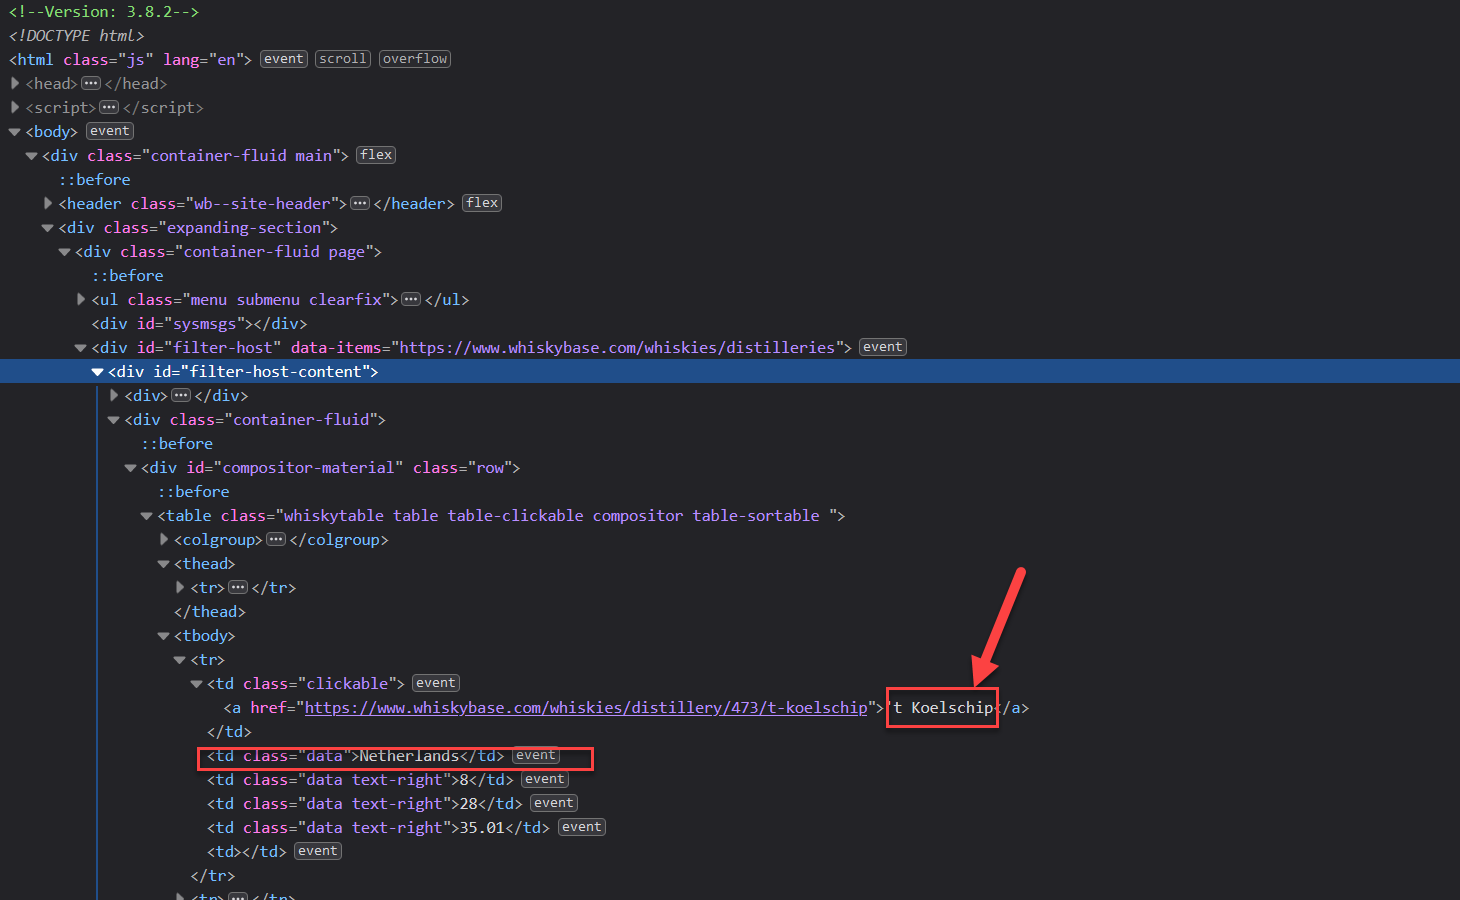

##### Create Empty Dataset to Write To

In [5]:
whisky = pd.DataFrame(columns=['Distillery Name','Country'])
whisky.head()

,Distillery Name,Country


##### Isolate Table/Row Data to Get Distillery Name and Country

In [11]:
# Portion of Script setting up a starting time so the total runtime to web scrape is calculated
start_time = datetime.now()

In [12]:
#Using the identified sections of the HTML from the area highlighted above, we use soup.find() to isolate the section/table continaing  the rows of the distillery data for mining.
table = soup.find('div', attrs = {'id':'compositor-material','class':'row'})

whisky = []

#Iterative function cycles through each row - delineated by 'tr' so that we can grab the distillery name and country from the web page
for row in table.findAll('tr'):
    data = {}
    data['distillery'] = row.a.text
    data['country'] = row.text.split('\t\t\t')[2]
    whisky.append(data)

whisky.pop(0) #Deletes first entry in list which is HTML text blurb
distilleries = pd.DataFrame(whisky)
distilleries.head()

,distillery,country
0,'t Koelschip,Netherlands
1,1000 Hills Distillery,Rwanda
2,10th Mountain,United States
3,10th Street Distillery,United States
4,117° West Spirits,United States


In [13]:
# Calculation of total runtime to show duration
end_time = datetime.now()
runtime = end_time-start_time
print(f"The time of execution of above section of code is : {runtime}")

The time of execution of above section of code is : 0:00:03.610903 s


The benefit of Beautiful Soup is that when you've isolated specifically the cells and data you want, the writing off of said data to a dataframe takes no time whatsover. Reading through the entire table on the webpage and writing off 2191 rows of data took only 3.6 seconds in this example. Now moving forward to the geolocation coordinate data however will show where the high runtime comes from for this effort.

### Gather Location Coordinates from Country

The goal is to use the listed country from the whiskybase data to get a lat/long for the respective country for data visualization purposes in Tableau.

##### Import Required Libraries

In [14]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

##### Create Function to find Address and Coordinates

In [15]:
#Create generic function to find coordinates of a given input location variable (country, company name, address) using the geocode functionality from geopy

def findGeocode(location_var):
    try:
        geolocator = Nominatim(user_agent="http")      
        return geolocator.geocode(location_var, timeout=None)
    except GeocoderTimedOut:
        return findGeocode(location_var) 

The first desired outcome is to simply use the distillery name to isolate an address. However, there are limitations to how accurate the Geopy package is at isolating the correct address. As a result we will break this effort into two steps. First is to use the function created above to populate an address based on Distillery Name & then isolate the lat/long/country from that address. Second step will then be to process the listed/found country against the one mined from Whiskeybase and where they don't match, replace the found lat/long with a central lat/long from the country as isolated from Whiskeybase.

In [ ]:
# Gather Lat/Long, Country for each returned address found in searching for Company Name

start_time = datetime.now()

# Empty Lists for Lat/Longs
longitude = []
latitude = []
loc_country = []

#Find details
for i in (distilleries["distillery"]):
    if findGeocode(i) != None:           
        loc = findGeocode(i) #Finds a full listing of the company name to include address, lat/long, country, and more
        latitude.append(loc.latitude) # Isolates Latitude & writes to list
        longitude.append(loc.longitude) # Isolates Longitude & writes to list
        loc_country.append(loc.raw['display_name'].rsplit(',',1)[-1].lstrip()) # Isolates Country from Address & writes to list
    else: #If Unable to Find, fills with a null value
        latitude.append(np.nan) 
        longitude.append(np.nan)
        loc_country.append(np.nan)

end_time = datetime.now()
duration = end_time - start_time

In [18]:
print(f"The time of execution of above section of code is : {duration} ")

The time of execution of above section of code is : 0:29:03.229905 


One of the cons of using Geopy is the fact that the application often runs into time-outs. s a result there's a component of the function written above that incorporates a pathway around the time-outs, but as a result the length of time taken to run and query to get coordinate information is quite intensive. As shown with the above cell, running this script on a fast internet system takes approximately 15 minutes for ~2200 records while on slower and metered internet can take upwards of 29 minutes.

In [20]:
#Create Final Dataframe by appending lists to become new columns in the base dataset mined from Whiskeybase
distilleries['address_latitude'] = latitude
distilleries['address_longitude'] = longitude
distilleries['address_country'] = loc_country
distilleries.head()

,distillery,country,address_latitude,address_longitude,address_country
0,'t Koelschip,Netherlands,51.230515,2.911864,België / Belgique / Belgien
1,1000 Hills Distillery,Rwanda,38.940478,-77.052783,United States
2,10th Mountain,United States,34.566618,-93.173342,United States
3,10th Street Distillery,United States,37.345137,-121.892493,United States
4,117° West Spirits,United States,41.500245,-81.699377,United States


For Instances where the address country doesn't match distillery listing country, gather Lat/Long coords for distillery listing country. If they match, we'll transfer the address based lat/long to equal the final lat/long, otherwise we'll use the country based lat/long to be the assigned final values as shown in the final dataset printout in two cells. As mentioned above, this portion takes some time to run,but as we're mitigating the need to run all the data by doing a data validation to see if the found country matches the scraped data, the number of geolocation searches is much smaller and thus runs faster than the entire dataset.

In [21]:
for index, row in distilleries.iterrows():
    if row["country"] == row['address_country']:
        distilleries.loc[distilleries.index == index, 'latitude'] =row['address_latitude']
        distilleries.loc[distilleries.index == index, 'longitude'] = row['address_longitude']
    else:
        loc = findGeocode(row["country"])
        distilleries.loc[distilleries.index == index, 'longitude']  = loc.longitude
        distilleries.loc[distilleries.index == index, 'latitude'] = loc.latitude

In [22]:
distilleries.head()

,distillery,country,address_latitude,address_longitude,address_country,longitude,latitude
0,'t Koelschip,Netherlands,51.230515,2.911864,België / Belgique / Belgien,5.634323,52.243498
1,1000 Hills Distillery,Rwanda,38.940478,-77.052783,United States,30.064436,-1.964663
2,10th Mountain,United States,34.566618,-93.173342,United States,-93.173342,34.566618
3,10th Street Distillery,United States,37.345137,-121.892493,United States,-121.892493,37.345137
4,117° West Spirits,United States,41.500245,-81.699377,United States,-81.699377,41.500245


### Print Data for Use in Data Viz

In [23]:
#Dropping the intermittent cell data and creating the final dataset of distillery, country, and lat/long.
distilleries = distilleries[['distillery','country','latitude','longitude']]

In [24]:
distilleries.to_csv('distillery_data.csv')